In [2]:
import pandas as pd
import os
import subprocess

# These are the files!

In [9]:
original_dir = '/global/cfs/cdirs/metatlas/raw_data/tharwood/20220211_JGI_MD_507130_BioS_final1_IDX_C18_USDAY59443_RENAME'
output_dir = '/pscratch/sd/b/bpb/bioscales_rhizosphere'
filter_string = '*NEG_MSMS*RZM*.h5'

In [1]:
### Preprocessing requirements
import pandas as pd
# 1. Copy all .h5 and .mzML files from the job folders to a single output directory for easier access.
# 2. Run the deconvolution to make <filename>_deconvoluted.parquet files.
import os
import numpy as np
from scipy.stats import ttest_ind
# import ztest
from statsmodels.stats.weightstats import ztest
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

PYTHONPATH = "/global/homes/b/bpb/repos/envnet"
if PYTHONPATH not in sys.path:
    sys.path.insert(0, PYTHONPATH)

from envnet.annotation.core import AnnotationEngine
annotation_engine = AnnotationEngine()
ref_dir = '/global/homes/b/bpb/repos/envnet/results/full_build_20250908_181404/'
node_data = annotation_engine.load_envnet_reference(
    graphml_file=os.path.join(ref_dir, "network_with_sirius.graphml"),
    mgf_base_name=os.path.join(ref_dir, "envnet")
)   
cols = [ 'dbe', 'dbe_ai',
       'dbe_ai_mod', 'ai_mod', 'ai', 'nosc', 'h_to_c', 'o_to_c', 'n_to_c',
       'p_to_c', 'c', 'h', 'o', 'n', 's', 'p', 'original_index','precursor_mz','inchi_key', 'compound_name', 'smiles','NPC#pathway', 'NPC#superclass', 'NPC#class','predicted_formula']

cols = ['original_index','predicted_unchanged_in_soil_prob', 'predicted_unchanged_in_soil']
model_data = pd.read_csv('../envnet/data/node_data_with_predicted_unchanged_20251107.csv', usecols=cols)
node_data['nodes'] = node_data['nodes'].merge(model_data, on='original_index', how='left')

Loading ENVnet reference data...
  GraphML file: /global/homes/b/bpb/repos/envnet/results/full_build_20250908_181404/network_with_sirius.graphml
  Deconvoluted MGF: /global/u2/b/bpb/repos/envnet/data//global/homes/b/bpb/repos/envnet/results/full_build_20250908_181404/envnet_deconvoluted_spectra.mgf
  Original MGF: /global/u2/b/bpb/repos/envnet/data//global/homes/b/bpb/repos/envnet/results/full_build_20250908_181404/envnet_original_spectra.mgf
Loaded 22128 ENVnet nodes
Loaded 22128 ENVnet nodes


In [2]:
data_path = '/pscratch/sd/b/bpb/bioscales_rhizosphere/'
ms1_filename = os.path.join(data_path,'ms1_results','ms1_annotations.parquet')
ms2_filename = os.path.join(data_path,'ms2_results','ms2_deconvoluted_annotations.parquet')

In [3]:
chemotype_map = {'BESC-13': 'L-PCA',
 'BESC-133': 'H-PCA',
 'BESC-198': 'H-PCA',
 'BESC-234': 'L-ALA',
 'BESC-258': 'L-FA',
 'BESC-285': 'H-FA',
 'BESC-307': 'H-PCA',
 'BESC-331': 'L-PCA',
 'BESC-351': 'H-ALA',
 'BESC-360': 'H-PCA',
 'BESC-388': 'L-ALA',
 'BESC-448': 'H-FA',
 'BESC-470': 'L-PCA',
 'BESC-56': 'H-FA',
 'BESC-833': 'H-PCA',
 'BESC-845': 'H-ALA',
 'BESC-847': 'L-FA',
 'BESC-86': 'H-ALA, H-FA',
 'BESC-866': 'H-ALA, H-PCA',
 'BESC-904': 'H-ALA',
 'BESC-905': 'H-ALA',
 'GW-11047': 'L-ALA',
 'GW-4579': 'L-PCA',
 'GW-7986': 'L-FA',
 'GW-9591': 'L-ALA',
 'SKWA-24-3': 'L-ALA, L-FA',
 'SKWD-24-1': 'H-PCA'}


In [176]:
ms1_df = pd.read_parquet(ms1_filename)
ms1_df['sample_type'] = ms1_df['lcmsrun_observed'].apply(lambda x: os.path.basename(x).split('_')[12])
ms1_df['replicate'] = ms1_df['lcmsrun_observed'].apply(lambda x: os.path.basename(x).split('_')[13])
ms1_df = ms1_df[~ms1_df['sample_type'].str.contains('ExCtrl')]
ms1_df['genotype'] = ms1_df['sample_type'].apply(lambda x: '-'.join(x.split('-')[:-2]))
ms1_df['location'] = ms1_df['sample_type'].apply(lambda x: x.split('-')[-2])

ms2_df = pd.read_parquet(ms2_filename)

ms1_df = ms1_df[ms1_df['original_index'].isin(ms2_df['original_index_deconvoluted_match'].unique())]

name_map = {'Clat':'Clatskanie','Corv':'Corvallis'}
ms1_df['location'] = ms1_df['location'].map(name_map)
ms1_df['chemotype'] = ms1_df['genotype'].map(chemotype_map)

ms1_df = pd.merge(ms1_df, node_data['nodes'][['original_index','predicted_unchanged_in_soil','NPC#class','NPC#superclass','compound_name']], on='original_index', how='left')

Text(0.01, 0.85, 'b')

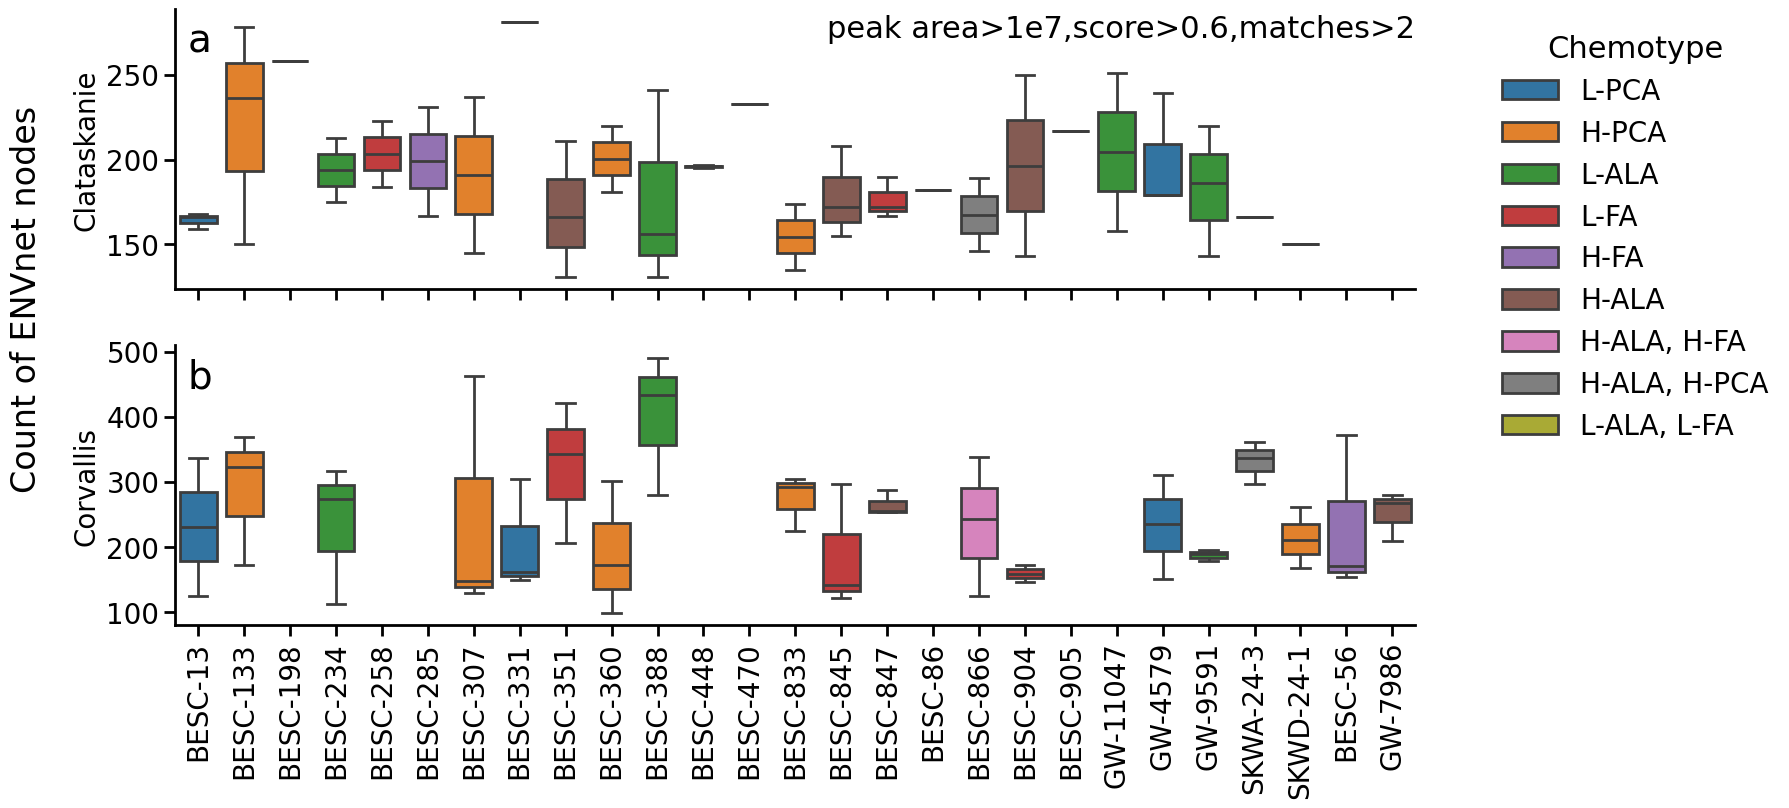

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
# g = ms1_df.groupby(['genotype','location','replicate'])['peak_area'].median().reset_index()
# count matches greater than 1e7 peak aera
g = ms1_df[ms1_df['peak_area'] > 1e7].groupby(['genotype','location','replicate','chemotype'])['peak_area'].count().reset_index()

# sns.boxplot(data=g, x='genotype', y='peak_area', hue='chemotype', ax=ax,subplot='location')
# rotate x labels
# plt.xticks(rotation=90, ha='center')
# ax.set_ylabel('Count of ENVnet nodes\n(peak area>1e7,score>0.6,matches>2)')
fig,ax = plt.subplots(figsize=(16,8),nrows=2,ncols=1,sharex=True)
idx = g['location']=='Clatskanie'
sns.boxplot(data=g[idx], x='genotype', y='peak_area', hue='chemotype', ax=ax[0],linewidth=2)
plt.yticks(fontsize=20)

idx = g['location']=='Corvallis'
sns.boxplot(data=g[idx], x='genotype', y='peak_area', hue='chemotype', ax=ax[1],linewidth=2)
plt.xticks(rotation=90, ha='center',fontsize=20)

for a in ax:
    a.tick_params(axis='x', labelsize=20)
    a.tick_params(axis='y', labelsize=20)
    # set linewidth of axis lines and ticks
    for axis in ['bottom','left']:
        a.spines[axis].set_linewidth(2)
    # make ticks longer and wider
    a.tick_params(axis='both', which='major', length=8, width=2)

ax[0].set_ylabel('Clataskanie',fontsize=20)
ax[1].set_ylabel('Corvallis',fontsize=20)
# move legend outside
ax[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left',fontsize=20,title='Chemotype',title_fontsize=22,frameon=False)
# clear second legend
ax[1].legend_.remove()
ax[1].set_xlabel('')
# remov top and right spines
sns.despine()
ax[0].text(1, 0.9, 'peak area>1e7,score>0.6,matches>2', transform=ax[0].transAxes, fontsize=22, ha='right')
ax[0].text(-0.12, -0.70, 'Count of ENVnet nodes', rotation=90,transform=ax[0].transAxes, fontsize=24, ha='center')
# add panel a,b labels
ax[0].text(0.01, 0.85, 'a', transform=ax[0].transAxes, fontsize=28)
ax[1].text(0.01, 0.85, 'b', transform=ax[1].transAxes, fontsize=28)

In [153]:
from sklearn.feature_selection import f_classif, SelectKBest
# X = Your DataFrame of metabolites (rows=samples, cols=compounds)
# y = Your labels (e.g., 'BESC-133', 'BESC-13', etc. OR 'H-PCA', 'L-ALA')

idx1 = ms1_df['peak_area'] > 1e7
idx2 = ms1_df['location'] =='Corvallis'
# idx3 = pd.notna(ms1_df['compound_name'])
g = ms1_df[idx1 & idx2].groupby(['genotype','location','chemotype','replicate','original_index'])['peak_area'].sum().reset_index()
X = pd.pivot_table(g,index=['genotype','chemotype','replicate'],columns=['original_index'],values='peak_area',fill_value=0)
y = X.index.get_level_values(0)
# # Keep the top 10 features with the highest F-scores
selector = SelectKBest(score_func=f_classif, k=10)
X_reduced = selector.fit_transform(X, y)

# # You can also just get the F-scores directly without transforming
f_scores, p_values = f_classif(X, y)


89


/tmp/ipykernel_1120670/41771610.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top5 = top5.append({'NPC#superclass': 'Other', 'original_index': other_sum}, ignore_index=True)


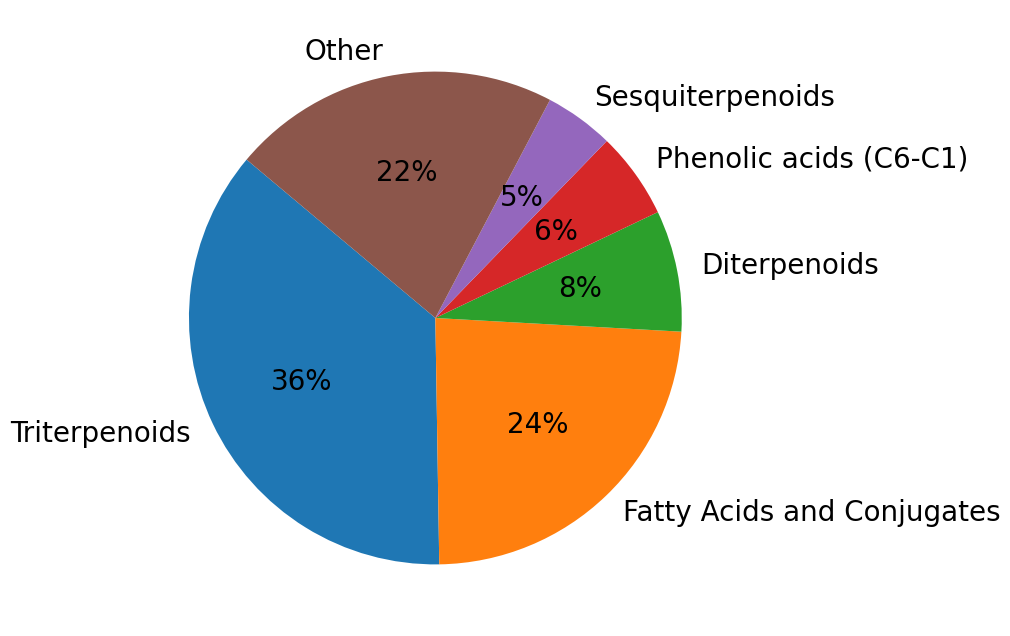

In [181]:
from sklearn.feature_selection import f_classif, SelectKBest
# X = Your DataFrame of metabolites (rows=samples, cols=compounds)
# y = Your labels (e.g., 'BESC-133', 'BESC-13', etc. OR 'H-PCA', 'L-ALA')

idx1 = ms1_df['peak_area'] > 1e7
idx2 = ms1_df['location'] =='Corvallis'
# idx2 = ms1_df['location'] =='Clatskanie'
# idx3 = pd.notna(ms1_df['compound_name'])
g = ms1_df[idx1 & idx2].groupby(['genotype','location','chemotype','replicate','original_index'])['peak_area'].sum().reset_index()
X = pd.pivot_table(g,index=['genotype','chemotype','replicate'],columns=['original_index'],values='peak_area',fill_value=0)
y = X.index.get_level_values(0)
# # Keep the top 10 features with the highest F-scores
selector = SelectKBest(score_func=f_classif, k=10)
X_reduced = selector.fit_transform(X, y)

# # You can also just get the F-scores directly without transforming
f_scores, p_values = f_classif(X, y)


idx = p_values<0.05
print(sum(idx))
# get columns in idx
cols = X.columns
my_data = X[cols[idx]].copy()
cols = my_data.columns
my_data.reset_index(inplace=True)

select_cols = ['original_index', 'predicted_unchanged_in_soil', 'NPC#superclass',
       'compound_name']
my_slice = ms1_df.loc[ms1_df['original_index'].isin(cols),select_cols].drop_duplicates()
g = my_slice.groupby('NPC#superclass')['original_index'].count().reset_index()

# make a pie chart of the counts for the top 5 classes
top5 = g.sort_values('original_index', ascending=False).head(5)
top5_sum = top5['original_index'].sum()
other_sum = g['original_index'].sum() - top5_sum
top5 = top5.append({'NPC#superclass': 'Other', 'original_index': other_sum}, ignore_index=True)
fig, ax = plt.subplots(figsize=(8,8))
ax.pie(top5['original_index'], labels=top5['NPC#superclass'], autopct='%1.0f%%', startangle=140,colors=sns.color_palette('tab10'), textprops={'fontsize': 20})
# ax.set_title('Distribution of Top 10 NPC#classes among Significant Features', fontsize=16)  
plt.show()
